In [1]:
import pandas as pd
from collections import Counter
import sys
import numpy as np
from matplotlib.pylab import plt
pd.options.mode.chained_assignment = None
from IPython.display import Image, display

import torch
import torch.nn as nn
from torch.nn import functional as F
import ast
from dataclasses import dataclass
from contextlib import nullcontext
import pickle, dill
from unidecode import unidecode

sys.path.insert(1, '../')
from utils.data_utility import DataUtil
from utils.helper import estimate_loss, get_batch
from utils.attention_block import GPTLanguageModel
from tokenizers import ByteLevelBPETokenizer

%load_ext autoreload
%autoreload 2





number of words  15141


# Data

In [2]:
# Skip this step and go to the next cell if you have your own text file you want to use.  

In [3]:
path_to_data = '../data/'
dutil = DataUtil()
df_science = pd.read_csv(path_to_data + 'askscience_data.csv').drop('Unnamed: 0',axis=1)
texts  = list(df_science['title'].dropna())
texts += list(df_science['body'].dropna())

text_data = [" ".join(y.lower().replace('?',' ').replace("!"," ").replace(',',' ').replace(';',' ').replace("\"","").replace('(',' ').replace(')',' ').replace('[',' ').replace(': ',' ').replace(']',' ').replace(". "," . ").replace('-',' ').replace('*','').replace("“","").replace("”","").replace('_',' ').split()) for y in texts] # vectorized text data
text_data = [unidecode(y) for y in text_data ] # vectorized text data
final_text = []
for y in text_data:
    ws = []
    for w in y.split():
        if 'http' not in w: # vectorized text data
            ws.append(w)
    final_text.append("<s> " +  ' '.join(ws).replace('/',' ')+ " </s>")
        
text_data = final_text         

FromDrive = 0
myOwn = 0

In [4]:
f = open(path_to_data + 'training_text.txt','w')
for t in text_data: 
    f.write( "<s> " + t + " </s>")
    f.write(' \n')

# Tokenizer

In [5]:

path = [path_to_data + 'training_text.txt']
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=path, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

tokenizer.enable_padding(pad_token='</s>')
end_token_id = tokenizer.token_to_id('</s>')
start_token_id = tokenizer.token_to_id('<s>')
pad_token_id = end_token_id


encode = lambda s: tokenizer.encode(s).ids
decode = lambda l: tokenizer.decode(l)

vocab_size = tokenizer.get_vocab_size()
print("number of words " , vocab_size)

tokenizer.encode('<s> hi how are you? </s>').ids
# Save files to disk
tokenizer.save_model(path_to_data, "redditTok")




number of words  15116


['../data/redditTok-vocab.json', '../data/redditTok-merges.txt']

In [6]:
tokenizer.decode(tokenizer.encode('<s> hi how are you? </s>').ids)

' hi how are you? '

median lenght 24 


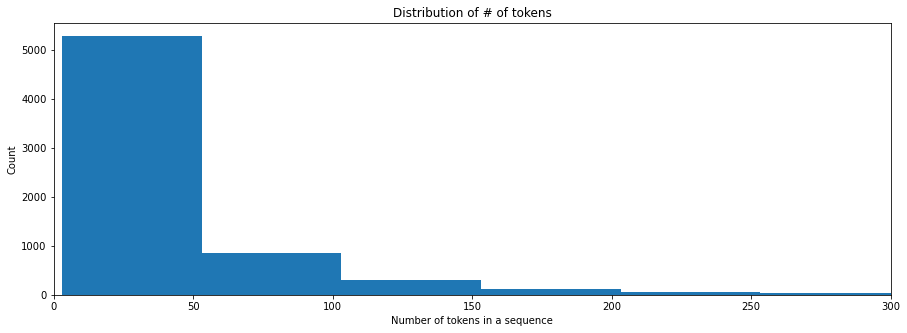

In [7]:
len_tokens = [len(encode(x)) for x in text_data]

plt.figure(figsize=(15,5))
plt.hist(len_tokens,20);

ax = plt.gca()

plt.title("Distribution of # of tokens")
plt.xlabel("Number of tokens in a sequence")
plt.ylabel("Count")
ax.set_xlim([0, 300])

print(f"median lenght %d "%np.median(len_tokens))

block_size = 64 
tokenizer.enable_truncation(max_length=block_size)

# Hyperparameters

In [8]:
max_iters = 2000
eval_interval = 40
learning_rate = 1e-5


@dataclass
class GPTConfig:
    block_size: int = block_size
    vocab_size: int = vocab_size
    n_layer: int = 8
    n_head: int = 8
    n_embd: int = 512
    dropout: float = 0.2
    batch_size: int = 32
    temperature=1.0 
    top_k=20
        
config = GPTConfig()

dill.dump(config,open(path_to_data + 'scratch_reddit_gpt_config.pickle','wb'))


device = 'cuda' if torch.cuda.is_available() else 'cpu'


torch.manual_seed(1337)

Chunking data to be around median length. could help avoiding adding too many padding tokens later 

In [9]:
sequences = []
for text in text_data :
    words_ = text.split()
    b = [0,config.block_size]
    if len(words_) >= config.block_size: 
            words_seg = words_[b[0]:b[1]]
            sequences.append(' '.join(words_seg))
            b[0] += config.block_size
            b[1] += config.block_size
    else: 
        sequences.append(' '.join(words_))
    

# Train and validation splits

In [10]:
# padding sequences to be of the same size
data_ids = []
for seq in sequences:
    ids = encode(seq)
    if len(ids) == block_size: 
        ids[0] = start_token_id
        ids[-1] = end_token_id
        
    elif len(ids) < block_size: 
        ids[0] = start_token_id
        ids[-1] = pad_token_id
        while len(ids) != block_size: 
            ids.append(pad_token_id)
        ids[-1] = end_token_id
    data_ids.append(ids)

In [11]:
data_ids = torch.tensor(data_ids, dtype=torch.long)

n = int(0.95*len(data_ids)) # first 95% will be train, rest val
train_data = data_ids[:n]
val_data = data_ids[n:]

print("Number of training data " , len(train_data))
print("Number of validation data " , len(val_data))

pickle.dump(train_data , open(path_to_data + 'train_data.pickle','wb'))
pickle.dump(val_data , open(path_to_data + 'valid_data.pickle','wb'))

Number of training data  6362
Number of validation data  335


## Data Loader

In [12]:
print(f"trianing data (batch_size %d , block_size %d)"%(get_batch('train')[0].shape))

trianing data (batch_size 32 , block_size 63)


# Self Attention - Decoder 

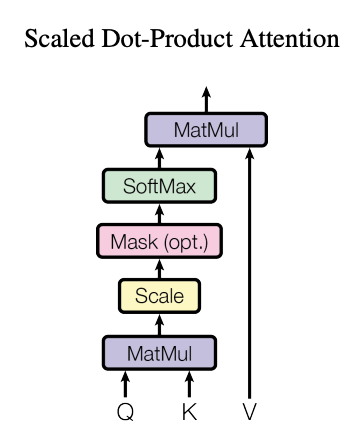

In [13]:
display(Image(filename='../snapshots/head.png'))

To paraphrase Andrej K., 

" We want the [words] to know about each other, information from the past.  Every single token emits two vectors, a query anda a key vector. Query is what am I looking for and key is what do I contain? The dot product of these two vector is maximized when the query and key are aligned which helps attention learn more about that specific token. "


Text(0.5, 1.0, 'v after Lora')

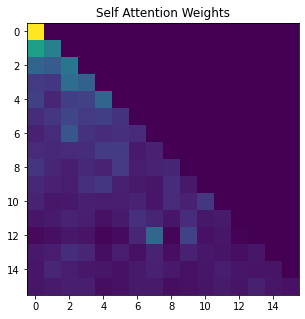

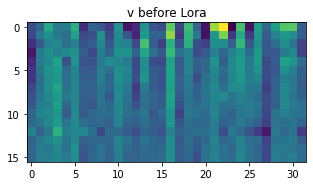

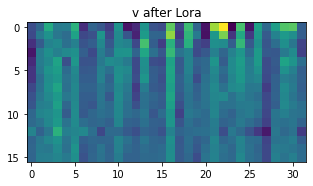

In [14]:
B = 1 # batch size
T = 16 # time stamps
C = 32 # embedding dim
head_size = 16 # head size 
x = torch.randn(B,T,C) # token embedding

key   = nn.Linear(C, head_size, bias=False) # (C, hs)
query = nn.Linear(C, head_size, bias=False) # (C, hs)

k = key(x)  # (B, T, hs)
q = query(x)# (B, T, hs)

# Dot product followed by scaling 
# Scaling is important for softmax, specially in the early layers. 
# Scaling will help reduce the std ensuring the values won't get too large 
# in the softmax 

wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril==0,float('-inf'))
wei = F.softmax(wei,dim=-1) # (B, T, T)
v = wei @ x

plt.figure(figsize=(5,5))
plt.imshow(wei.detach().numpy()[0,:,:])
plt.title("Self Attention Weights")

plt.figure(figsize=(5,5))
plt.imshow(v.detach().numpy()[0,:,:])
plt.title("v before Lora")

# add LoRA 
rank = 8
W_A = nn.Parameter(torch.empty(T, rank)) # LoRA weight A
W_B = nn.Parameter(torch.empty(rank, C))
nn.init.kaiming_uniform_(W_A, a=np.sqrt(5))
nn.init.zeros_(W_B)

v += W_A@W_B
plt.figure(figsize=(5,5))
plt.imshow(v.detach().numpy()[0,:,:])
plt.title("v after Lora")

# hyperparameters

In [15]:
# From scratch
if FromDrive == 0:
    model = GPTLanguageModel(config)
    model = model.to(device)
else:
    print("loading from cache")
    # Further training an existing one
    model  = torch.load(path_to_data + 'scratch_reddit_gpt2')
    model = model.to(device)
    config = pickle.load(open(path_to_data + 'scratch_reddit_gpt_config.pickle','rb'))

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(sum([p.numel()/1e6 for p in model.parameters() if p.requires_grad]) , 'M trainable parameters')
print( "random loss" , -np.log10(1/vocab_size))

40.734476000000164 M trainable parameters
random loss 4.179436883244977


In [ ]:
start = '<s>'
context = torch.tensor([encode(start)], dtype=torch.long, device=device)
        
for iter_ in range(max_iters):
    if iter_> 1 and iter_ % eval_interval == 0 or iter_ == max_iters - 1:
        decoded_context = decode(model.generate(context, max_new_tokens=32)[0].tolist())
        print(' '.join(decoded_context.split()))
        losses = estimate_loss(model)
        print("---")
        print(f"step {iter_}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f} \n")
        print("####################################################")
        
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
        
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    

In [ ]:
# Saving model and artifacts
torch.save(m, '../data/scratch_reddit_gpt_2' )
dill.dump(config,open(path_to_data + 'scratch_reddit_gpt_config.pickle','wb'))


# Decoding 

In [ ]:
# generate from the model
start = 'how '
context = torch.tensor([encode(start)], dtype=torch.long, device=device)
decoded_context = decode(m.generate(context, max_new_tokens=config.block_size)[0].tolist())
print(' '.join(decoded_context.split()))
